# **Import needed modules**

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-06-02 01:42:56.073290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748828576.545430      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748828576.660284      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/blood-cells-image-dataset


In [3]:
# Set the Kaggle-compatible dataset path
data_dir = "/kaggle/input/blood-cells-image-dataset"

filepaths = []
labels = []

# List the folders inside the dataset directory
folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    if fold in ['ig', 'neutrophil']:
        continue
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create the dataframe 
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Optional: preview
df.head() 

,filepaths,labels
0,/kaggle/input/blood-cells-image-dataset/bloodc...,bloodcells_dataset
1,/kaggle/input/blood-cells-image-dataset/bloodc...,bloodcells_dataset
2,/kaggle/input/blood-cells-image-dataset/bloodc...,bloodcells_dataset
3,/kaggle/input/blood-cells-image-dataset/bloodc...,bloodcells_dataset
4,/kaggle/input/blood-cells-image-dataset/bloodc...,bloodcells_dataset


In [4]:
import os
import pandas as pd

# Set the dataset path (Kaggle-compatible)
data_dir = '/kaggle/input/blood-cells-image-dataset/bloodcells_dataset/'
filepaths = []
labels = []

# List all subfolders (classes) in the dataset directory
folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    
    # Check if it's a directory (skip any hidden or non-folder items)
    if not os.path.isdir(foldpath):
        continue
    
    # List all image files in the folder
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create the DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Preview the data
df.head()


,filepaths,labels
0,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
1,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
2,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
3,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
4,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte


In [5]:
df

,filepaths,labels
0,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
1,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
2,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
3,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
4,/kaggle/input/blood-cells-image-dataset/bloodc...,monocyte
...,...,...
17087,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
17088,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
17089,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet
17090,/kaggle/input/blood-cells-image-dataset/bloodc...,platelet


In [6]:
df.describe()

,filepaths,labels
count,17092,17092
unique,17092,8
top,/kaggle/input/blood-cells-image-dataset/bloodc...,neutrophil
freq,1,3329


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17092 entries, 0 to 17091
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  17092 non-null  object
 1   labels     17092 non-null  object
dtypes: object(2)
memory usage: 267.2+ KB


### **Split dataframe into train, valid, and test**

In [8]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size) 

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size) 

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size) 

Found 13673 validated image filenames belonging to 8 classes.
Found 2051 validated image filenames belonging to 8 classes.
Found 1368 validated image filenames belonging to 8 classes.


### **Show sample from train data**

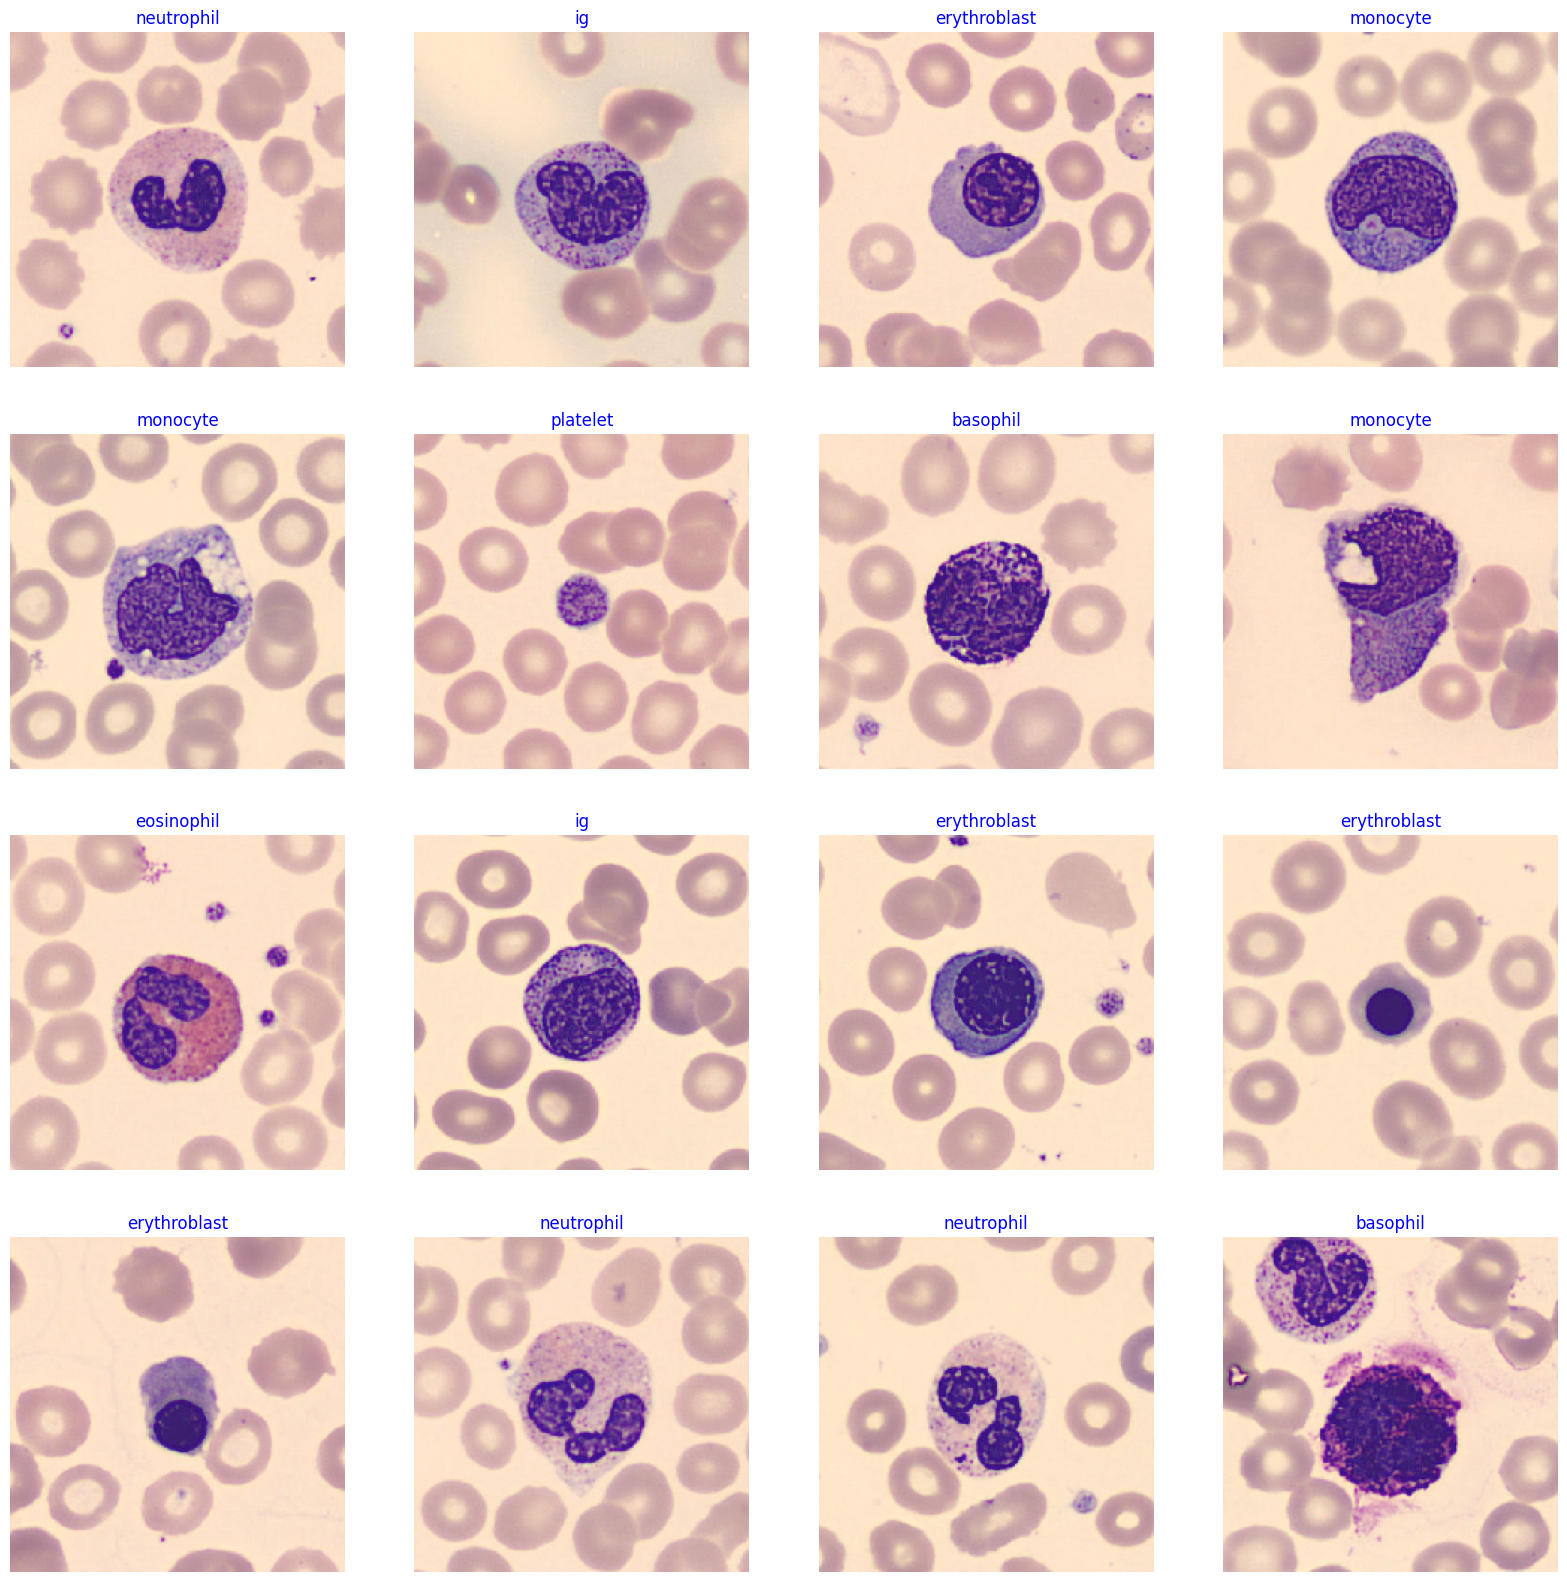

In [ ]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255   
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]  
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show() 

# **Model Structure**

#### **Generic Model Creation**

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

I0000 00:00:1748828647.604098      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748828647.604765      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,185,207 (42.67 MB)

 Trainable params: 11,094,832 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

#### **Train model**

In [12]:
epochs = 30
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False
)

Epoch 1/30


I0000 00:00:1748828732.033459      65 service.cc:148] XLA service 0x7e89581346f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748828732.034807      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748828732.034834      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748828738.867950      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748828752.469644      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748828752.610834      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748828752.971027      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

854/855 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4133 - loss: 9.3106

E0000 00:00:1748828915.432051      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748828915.570609      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


855/855 ━━━━━━━━━━━━━━━━━━━━ 326s 226ms/step - accuracy: 0.4134 - loss: 9.3043 - val_accuracy: 0.5495 - val_loss: 3.9158
Epoch 2/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 125s 146ms/step - accuracy: 0.5241 - loss: 3.4039 - val_accuracy: 0.6290 - val_loss: 2.0396
Epoch 3/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.6112 - loss: 1.9790 - val_accuracy: 0.7650 - val_loss: 1.3236
Epoch 4/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.7181 - loss: 1.4571 - val_accuracy: 0.9615 - val_loss: 0.9407
Epoch 5/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.8620 - loss: 1.1472 - val_accuracy: 0.9191 - val_loss: 0.8633
Epoch 6/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.8927 - loss: 0.9712 - val_accuracy: 0.9820 - val_loss: 0.6357
Epoch 7/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.9000 - loss: 0.8804 - val_accuracy: 0.9703 - val_loss: 0.6235
Epoch 8/30
855/855 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.9152 - loss: 0.79

#### **Display model performance**

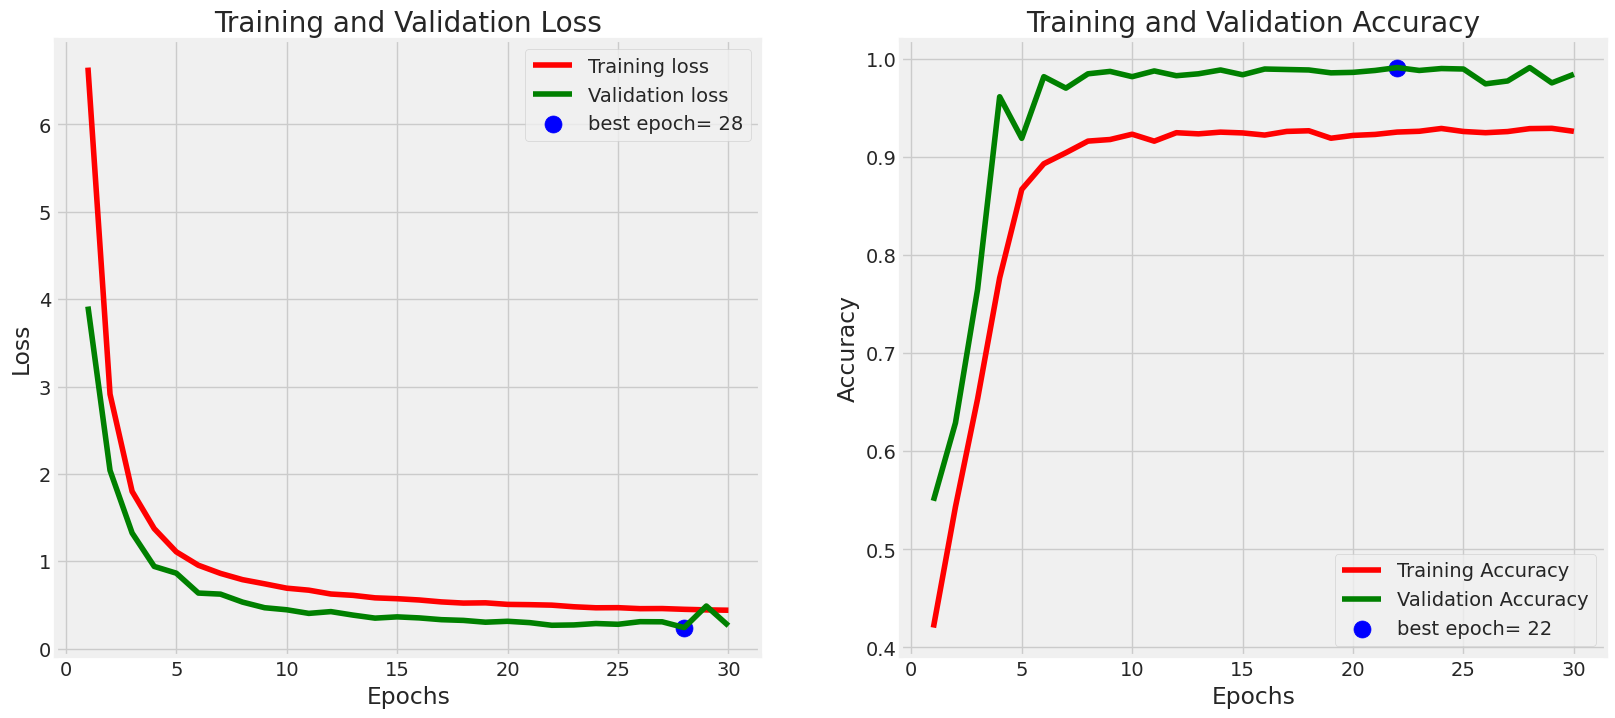

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1]) 
print('-' * 20) 
print("Test Loss: ", test_score[0]) 
print("Test Accuracy: ", test_score[1]) 

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9985 - loss: 0.2142
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9638 - loss: 0.3018
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9843 - loss: 0.2719
Train Loss:  0.21458600461483002
Train Accuracy:  0.9965277910232544
--------------------
Validation Loss:  0.2707969844341278
Validation Accuracy:  0.9756944179534912
--------------------
Test Loss:  0.24762585759162903
Test Accuracy:  0.9895833134651184


# **Get Predictions**

In [15]:
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 

86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step


#### **Confusion Matrics and Classification Report**

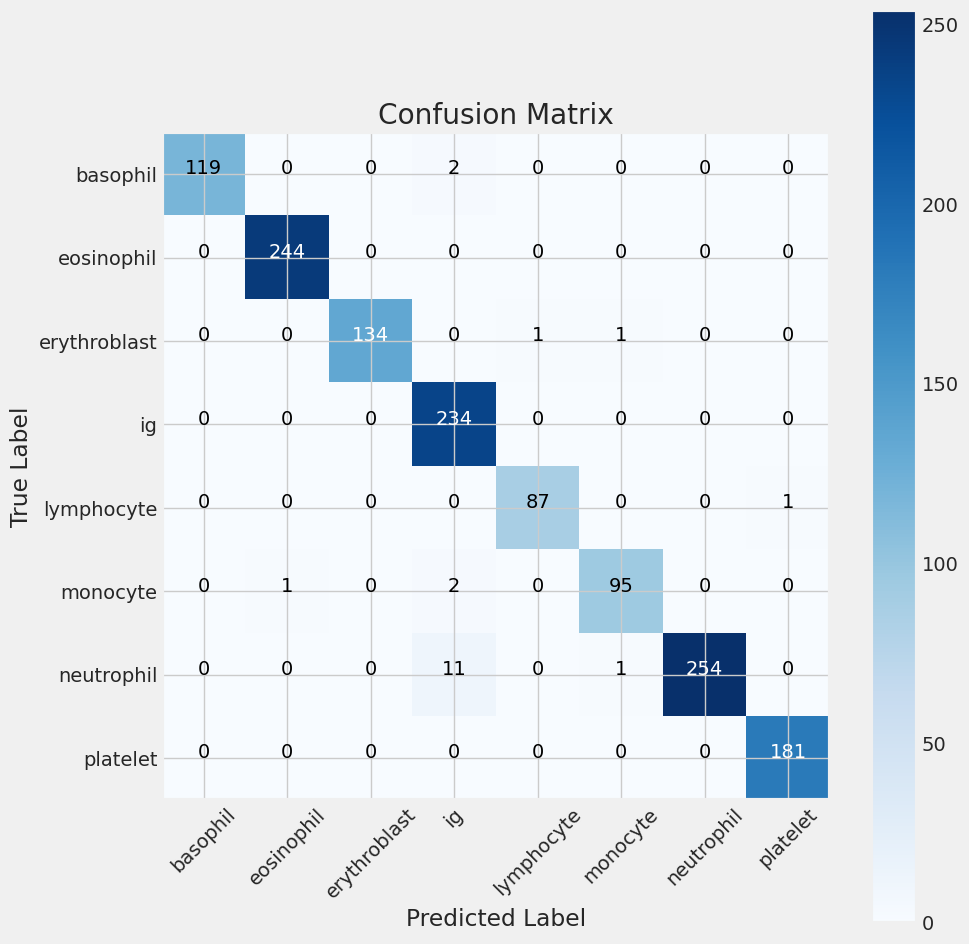

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [17]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       1.00      0.98      0.99       121
  eosinophil       1.00      1.00      1.00       244
erythroblast       1.00      0.99      0.99       136
          ig       0.94      1.00      0.97       234
  lymphocyte       0.99      0.99      0.99        88
    monocyte       0.98      0.97      0.97        98
  neutrophil       1.00      0.95      0.98       266
    platelet       0.99      1.00      1.00       181

    accuracy                           0.99      1368
   macro avg       0.99      0.99      0.99      1368
weighted avg       0.99      0.99      0.99      1368



#### **Save model**

In [18]:
#Save the model
model.save('Bloods.h5')